In [ ]:
BASE_BUILDING = 1
BASE_FLOOR = 1 

BUILDING = 2
FLOOR = 3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import pandas as pd 
import torchvision
from torchvision import datasets, transforms
from torch import nn,optim
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
def Plot2Dlocation(np_xy_truth, list_xy_preds,result_path, dataset_name, plot_name, connectDots=True,saveFlag=False):
    """
    Plot the 2D map with the ground truth and prediction results (list_xy_preds could hold 1 set of results or more)
    :param main_info (HouseKeeping):
    :param np_xy_truth (Numpy):
    :param list_xy_preds (List<String,2d_np>): e.g. list_xy_preds=[["Euclidean",df_pred.values]]
    :param dataset_name (String):
    :param plot_name (String):
    :param connectDots (Bool):
    :param saveFlag (Bool):
    :return:
    """
    plt.clf()   #clear the plot
    fig, ax = plt.subplots(figsize=(16, 10))
    #Figure Info
    plt.title('{}\n({})'.format(plot_name,dataset_name))
    #plt.title(dataset_name,y=1)
    #plt.suptitle(plot_name, y=1.1, fontsize=18)
    #plt.title(dataset_name, fontsize=10)
    plt.xlabel('x')
    plt.ylabel('y')

    #plot groundtruth
    plt.plot(np_xy_truth[:,0], np_xy_truth[:,1], GRAPH_COLOUR[0]+MARKER[0],label="Ground Truth")

    #connect the points
    for caseNum in range(len(list_xy_preds)):
        #plot pred point (scatter)
        #plt.plot(list_xy_preds[caseNum][1][:, 0], list_xy_preds[caseNum][1][:, 1], GRAPH_COLOUR[caseNum+1] + MARKER[caseNum+1],label=list_xy_preds[caseNum][0])
        plt.scatter(list_xy_preds[caseNum][1][:, 0], list_xy_preds[caseNum][1][:, 1],c=GRAPH_COLOUR[caseNum+1],s=5,label=list_xy_preds[caseNum][0])

        if (connectDots):
            x = np.array([np_xy_truth[:, 0], list_xy_preds[caseNum][1][:, 0]])
            y = np.array([np_xy_truth[:, 1], list_xy_preds[caseNum][1][:, 1]])
            plt.plot(x, y, GRAPH_COLOUR[caseNum + 1], alpha=0.2)

    plt.legend()
    if saveFlag:
        saveName = join(result_path,dataset_name+"_"+plot_name+".png")
        plt.savefig(saveName)
    # plt.show()


    #endFunction Plot2Dlocation

def convert_data_to_tensor(np_data,device):
    return torch.tensor(np_data,dtype=torch.float32).to(device)

def create_data_loader(np_input, np_label, batch_size, shuffle=False):
    device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')

    input = Variable(convert_data_to_tensor(np_input,device))
    label = Variable(convert_data_to_tensor(np_label,device))

    if torch.cuda.is_available():
        input = input.cuda()
        label = label.cuda()

    data_loader = DataLoader(dataset=TensorDataset(input,label),
                             batch_size=batch_size,
                             shuffle=shuffle)
    return data_loader


def scale_data(rss_df):
    if not('pandas' in str(type(rss_df))):
        print("ERROR: Please Input Data in pandas.DataFrame")
        return -1

    new_rss = rss_df.copy()
    new_rss[new_rss == 100] = -110
    new_rss[new_rss == -100] = -110

    new_rss /= 110
    new_rss += 1
    return new_rss.values

def scale_xy(lon_lat, mean, std):
    return (lon_lat - mean) / std

def rescale_xy(scale_lon_lat, mean, std):
    scale_lon_lat = np.array(scale_lon_lat)
    lon = np.transpose(np.array([scale_lon_lat[:, 0]]))
    # lon = output[0]
    lon_rescaled = lon * std[0] + mean[0]

    lat = np.transpose(np.array([scale_lon_lat[:, 1]]))
    # lat = output[1]
    lat_rescaled = lat * std[1] + mean[1]
    return np.array([lon_rescaled, lat_rescaled]).transpose().reshape(-1,2)


def save_result (df_pred, df_true, data_name, case_name, save_path):
    # % SAVE RESULT
    df_result = df_pred.copy()

    df_result.join(df_true)
    file_path = join(save_path, "pred_{}_{}.csv".format(data_name,case_name))
    df_result.to_csv(file_path,header=True)


    # % Evaluate the Result
    eval_euclidean_distance(
        df_pred = df_pred,
        df_truth = df_true,
        dataset_name = data_name,
        case_name = case_name,
        save_path = save_path,
        run_time=-1,
        file_name="Eval_Results.csv",
        saveFlag=True
    )

    # Plot - Result
    Plot2Dlocation(df_true.values, [[case_name, df_pred.values]], save_path, data_name, case_name,
                   connectDots=True, saveFlag=True)

    print("-- [complete] save pred_{}_{}.csv".format(data_name,case_name))
#end save_result

In [ ]:
data = pd.read_csv('path-to-csv')
data = data[data["BuildingID"]==BUILDING]
data = data[data["FloorID"]==FLOOR]
label = data[["x","y"]]

#data = data.drop(columns=['type','timestamp','longitude','latitude','floor_id'])
data = data.drop(columns=["lon","lat","FloorID","BuildingID","locID","RELATIVEPOSITION","USERID","PHONEID","TIMESTAMP","pos_loc","SectionID","x","y"])
print(data)

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)




#Normalize training input data
X_train = scale_data(X_train)

#Normalize training label: 
mean = np.mean(y_train.values, axis=0)
std = np.std(y_train.values, axis=0)
label = scale_xy(y_train.values, mean, std)



#convert df to tensor object
data = torch.tensor(X_train)

label_t = torch.tensor(label)

#flatten 
data_t = torch.flatten(data,1)

label_t = torch.flatten(label_t,1)
print("data shape: " + str(data_t.shape))
print("label shape: " + str(label_t.shape))


train_data = [] 
for i in range(len(data_t)):
    train_data.append([data_t[i],label_t[i]])





       WAP001  WAP002  WAP003  WAP004  WAP005  WAP006  WAP007  WAP008  WAP009  \
32       -100    -100    -100     -97    -100    -100    -100    -100    -100   
33       -100    -100    -100    -100    -100    -100    -100    -100    -100   
34       -100    -100    -100    -100    -100    -100     -89    -100    -100   
35       -100    -100    -100    -100    -100    -100     -88    -100    -100   
36       -100    -100    -100    -100    -100    -100    -100    -100    -100   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
10084    -100    -100    -100    -100    -100    -100     -76    -100    -100   
10085    -100    -100    -100    -100    -100    -100    -100    -100    -100   
10086    -100    -100    -100    -100    -100    -100    -100    -100    -100   
10087    -100    -100    -100    -100    -100    -100    -100    -100    -100   
10090    -100    -100    -100    -100    -100    -100    -100    -100    -100   

       WAP010  ...  WAP511 

In [ ]:
#Normalize test input data 
X_test = scale_data(X_test) 

#Normalize training label
mean_val = np.mean(y_test.values, axis=0)
std_val = np.std(y_test.values, axis=0)
label_val = scale_xy(y_test.values, mean_val, std_val)




#convert df to tensor object
data_val_t1 = torch.tensor(X_test)

label_val_t = torch.tensor(label_val)

#flatten 
data_val_t = torch.flatten(data_val_t1,1)

label_val_t = torch.flatten(label_val_t,1)
print("data shape: " + str(data_val_t.shape))
print("label shape: " + str(label_val_t.shape))

val_data = [] 
for i in range(len(data_val_t)):
    val_data.append([data_val_t[i],label_val_t[i]])

data shape: torch.Size([387, 520])
label shape: torch.Size([387, 2])


In [ ]:
#put both train and validation sets into loader 
trainloader = torch.utils.data.DataLoader(train_data, batch_size=16)
testloader = torch.utils.data.DataLoader(val_data, batch_size=16)

print("Finish dataset part")

Finish dataset part


In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(data_val_t.shape[1],300)
        self.fc2 = nn.Linear(300,300)
        self.fc3 = nn.Linear(300,300)
        self.fc4 = nn.Linear(300,2)

        
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self,x):
        x = x.view(x.shape[0],-1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        
        return x
model = Classifier()
    


In [ ]:
import time 
model.load_state_dict(torch.load(f"/content/drive/MyDrive/FYP/UJI/UJI_MODEL_BUILDING{BASE_BUILDING}_FLOOR{BASE_FLOOR}"))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

LR = 0.0001


print(f"Computation device: {device}\n")

optimizer = optim.Adam(model.parameters(), lr= LR) 

criterion = nn.MSELoss() #MSE

epochs = 50
train_losses, test_losses = [],[]
times = []
for e in range(epochs):
    start_epoch = time.time()
    tot_train_loss = 0 
    for data, labels in trainloader:
        data, labels = data.to(device), labels.to(device)
        data = data.view(data.shape[0],-1)
        data = data.float()
        optimizer.zero_grad()
        output = model(data)

        loss = torch.sqrt(criterion(output,labels.float())) #RMSE 
        #loss = criterion(output,labels.float())
        tot_train_loss+=loss.item()
        
        loss.backward()
        optimizer.step()
        


    else:
        #if e>=100 and e%5==0 :
            #torch.save(model.state_dict(), './outputs/dec_control/dec-epoch-{}.pth'.format(e))
        tot_test_loss = 0 
        with torch.no_grad():
            for data, labels in testloader:
                data, labels = data.to(device), labels.to(device)
                data = data.view(data.shape[0],-1)
                data=data.float()
                test_output = model(data)
                loss = torch.sqrt(criterion(test_output,labels.float()))
                #loss = criterion(test_output,labels.float())

                tot_test_loss+=loss.item()
                
        train_loss = tot_train_loss/len(trainloader.dataset)
        test_loss = tot_test_loss/len(trainloader.dataset)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        end_epoch = time.time()
        elapsed = end_epoch - start_epoch 
        times.append(elapsed)

        print("Epoch:{}/{}..".format(e+1,epochs),
             "Training Loss:{:.3f}..".format(train_loss),
             "Test Loss:{:.3f}..".format(test_loss))


Computation device: cpu

Epoch:1/50.. Training Loss:0.061.. Test Loss:0.010..
Epoch:2/50.. Training Loss:0.030.. Test Loss:0.006..
Epoch:3/50.. Training Loss:0.022.. Test Loss:0.005..
Epoch:4/50.. Training Loss:0.019.. Test Loss:0.005..
Epoch:5/50.. Training Loss:0.018.. Test Loss:0.005..
Epoch:6/50.. Training Loss:0.017.. Test Loss:0.005..
Epoch:7/50.. Training Loss:0.017.. Test Loss:0.005..
Epoch:8/50.. Training Loss:0.016.. Test Loss:0.004..
Epoch:9/50.. Training Loss:0.016.. Test Loss:0.004..
Epoch:10/50.. Training Loss:0.015.. Test Loss:0.004..
Epoch:11/50.. Training Loss:0.014.. Test Loss:0.004..
Epoch:12/50.. Training Loss:0.015.. Test Loss:0.004..
Epoch:13/50.. Training Loss:0.014.. Test Loss:0.004..
Epoch:14/50.. Training Loss:0.013.. Test Loss:0.004..
Epoch:15/50.. Training Loss:0.014.. Test Loss:0.004..
Epoch:16/50.. Training Loss:0.013.. Test Loss:0.004..
Epoch:17/50.. Training Loss:0.013.. Test Loss:0.004..
Epoch:18/50.. Training Loss:0.013.. Test Loss:0.004..
Epoch:19/50.

In [ ]:
print(sum(times))


44.82832455635071


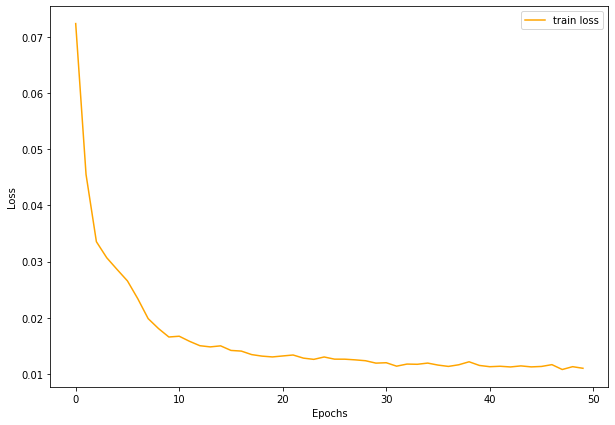

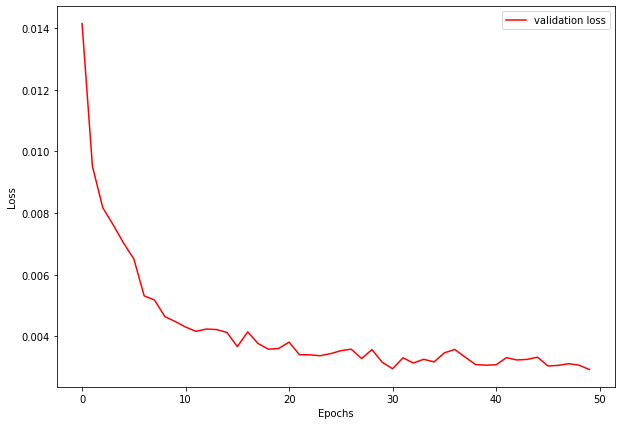

In [ ]:
import matplotlib.pyplot as plt


# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_losses, color='orange', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig(f"./outputs/{loss_plot_name}.png")
plt.show()

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(test_losses, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig(f"./outputs/{loss_plot_name}.png")
plt.show()

In [ ]:
#validation_loss, validation_pred = evaluate(data_val_t, label_val_t, model, criterion, mean, std)

data_val_new = pd.read_csv('path-to-csv')
data_val_new = data_val_new[data_val_new["BuildingID"]==BUILDING]
data_val_new = data_val_new[data_val_new["FloorID"]==FLOOR]
label_val_new = data_val_new[["x","y"]]



#Normalize  label: 
mean = np.mean(label_val_new.values, axis=0)
std = np.std(label_val_new.values, axis=0)
label = scale_xy(label_val_new.values, mean, std)

data_val_new = data_val_new.drop(columns=["lon","lat","FloorID","BuildingID","locID","RELATIVEPOSITION","USERID","PHONEID","TIMESTAMP","pos_loc","SectionID","x","y"])




In [ ]:
def evaluate(test_input, test_label, model, loss_fn, xy_mean, xy_std):
    model.eval()
    pred = model(convert_data_to_tensor(scale_data(test_input), device))
    val_loss = loss_fn(
        convert_data_to_tensor(rescale_xy(pred.data.cpu().numpy(), xy_mean, xy_std), device),
        convert_data_to_tensor(test_label, device)).data
    return val_loss.item(), rescale_xy(pred.data.cpu().numpy(), xy_mean, xy_std)

validation_loss, validation_pred = evaluate(data_val_new,label_val_new.values, model, criterion, mean, std)

In [ ]:
dist_list = [] 
for i in range(len(validation_pred)):
    dist = np.linalg.norm(validation_pred[i]-label_val_new.values[i])
    dist_list.append(dist)
    
print("Validation loss: " + str('{0:.2f}'.format(validation_loss)))
print("Average: " + str('{0:.2f}'.format(np.average(dist_list))) + " m")
print("Max: " + str('{0:.2f}'.format(max(dist_list))) + " m")
print("Min: " + str('{0:.2f}'.format(min(dist_list))) + " m")



Validation loss: 17.54
Average: 5.37 m
Max: 15.61 m
Min: 0.39 m


In [ ]:
temp_pred = [] 
for i in range(len(validation_pred)):
  temp_pred.append(validation_pred[i])
df_pred = pd.DataFrame(validation_pred)

<Figure size 432x288 with 0 Axes>

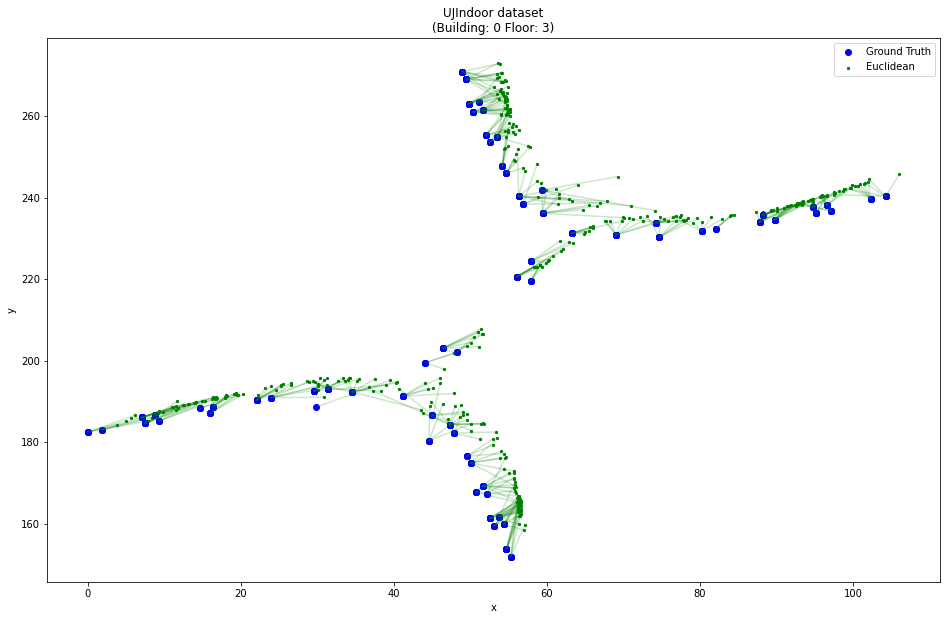

In [ ]:
GRAPH_COLOUR = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
MARKER = ['o', '.', ',', 'x', '+', 'v', '^', '<', '>', 's', 'd']


Plot2Dlocation(label_val_new.values, [["Euclidean",df_pred.values]],"test",f"Building: {BUILDING} Floor: {FLOOR}","UJIndoor dataset")

In [ ]:
dist_list = [] 
for i in range(len(validation_pred)):
    dist = np.linalg.norm(validation_pred[i]-label_val_new.values[i])
    dist_list.append(dist)
    
print("Validation loss: " + str('{0:.2f}'.format(validation_loss)))
print("Average: " + str('{0:.2f}'.format(np.average(dist_list))) + " m")
print("Max: " + str('{0:.2f}'.format(max(dist_list))) + " m")
print("Min: " + str('{0:.2f}'.format(min(dist_list))) + " m")



Validation loss: 17.54
Average: 5.37 m
Max: 15.61 m
Min: 0.39 m
